- Import Packes and modues

In [1]:
# import python packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import custom modules
from pmo_forcasting.core.settings import settings
from pmo_forcasting.data.handler import DataHandler
from pmo_forcasting.data.market_data_downloader import MarketDataDownloader
from pmo_forcasting.stats.financial_metrics import FinancialMetrics
from pmo_forcasting.stats.adf_test import ADFTester
from pmo_forcasting.preprocessing.outlier_detector import detect_outliers
# Plot settings (no seaborn to avoid errors)7
plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["axes.grid"] = True

- Data Loader and I/O

In [ ]:
import yfinance as yf
tickers = ["TSLA", "SPY", "BND"]

data = yf.download(
    tickers,
    start="2015-01-01",
    end="2026-01-15"
)["Close"]

# Drop missing values
data = data.dropna()

data.head()




In [2]:
# Output location
output_dir = settings.paths.DATA["raw_dir"]

downloader = MarketDataDownloader(
    config=settings.config,
    output_dir=output_dir,
)

df = downloader.run(force=True)

In [4]:
df.drop_duplicates()

,date,open,high,low,close,adj_close,volume,ticker,asset_class,risk_profile
5550,2015-01-02 00:00:00+00:00,82.430000,82.690002,82.419998,82.650002,60.385998,2218800,BND,bond,low
2775,2015-01-02 00:00:00+00:00,206.380005,206.880005,204.179993,205.429993,170.589645,121465900,SPY,equity,medium
0,2015-01-02 00:00:00+00:00,14.858000,14.883333,14.217333,14.620667,14.620667,71466000,TSLA,equity,high
5551,2015-01-05 00:00:00+00:00,82.739998,82.919998,82.699997,82.889999,60.561275,5820100,BND,bond,low
2776,2015-01-05 00:00:00+00:00,204.169998,204.369995,201.350006,201.720001,167.508804,169632600,SPY,equity,medium
...,...,...,...,...,...,...,...,...,...,...
5548,2026-01-13 00:00:00+00:00,695.489990,696.090027,691.349976,693.770020,693.770020,78309700,SPY,equity,medium
2773,2026-01-13 00:00:00+00:00,450.200012,451.809998,443.950012,447.200012,447.200012,53719200,TSLA,equity,high
8324,2026-01-14 00:00:00+00:00,74.320000,74.459999,74.320000,74.430000,74.430000,8765900,BND,bond,low
5549,2026-01-14 00:00:00+00:00,691.000000,691.719971,686.039978,690.359985,690.359985,94676700,SPY,equity,medium


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8325 entries, 5550 to 2774
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   date          8325 non-null   datetime64[ns, UTC]
 1   open          8325 non-null   float64            
 2   high          8325 non-null   float64            
 3   low           8325 non-null   float64            
 4   close         8325 non-null   float64            
 5   adj_close     8325 non-null   float64            
 6   volume        8325 non-null   int64              
 7   ticker        8325 non-null   object             
 8   asset_class   8325 non-null   object             
 9   risk_profile  8325 non-null   object             
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(3)
memory usage: 715.4+ KB


In [6]:
df.isna().sum()

date            0
open            0
high            0
low             0
close           0
adj_close       0
volume          0
ticker          0
asset_class     0
risk_profile    0
dtype: int64

In [7]:
df.dtypes

date            datetime64[ns, UTC]
open                        float64
high                        float64
low                         float64
close                       float64
adj_close                   float64
volume                        int64
ticker                       object
asset_class                  object
risk_profile                 object
dtype: object

In [8]:
# Summary statistics
df.describe()


,open,high,low,close,adj_close,volume
count,8325.000000,8325.000000,8325.000000,8325.000000,8325.000000,8.325000e+03
mean,193.287579,194.983801,191.459004,193.296215,181.624463,6.712758e+07
std,162.767162,164.011166,161.395776,162.768097,160.434449,6.640929e+07
min,9.488000,10.331333,9.403333,9.578000,9.578000,0.000000e+00
25%,74.029999,74.190002,73.879997,74.050003,63.490849,6.044400e+06
50%,93.066666,94.484001,89.440002,91.625999,91.625999,6.240820e+07
75%,286.440002,289.260010,283.779999,287.209991,266.860443,9.556050e+07
max,695.489990,696.090027,691.349976,695.159973,695.159973,9.140820e+08


Confirm no missing OHLCV values remain.

All columns have appropriate types (datetime64, float, int, object).

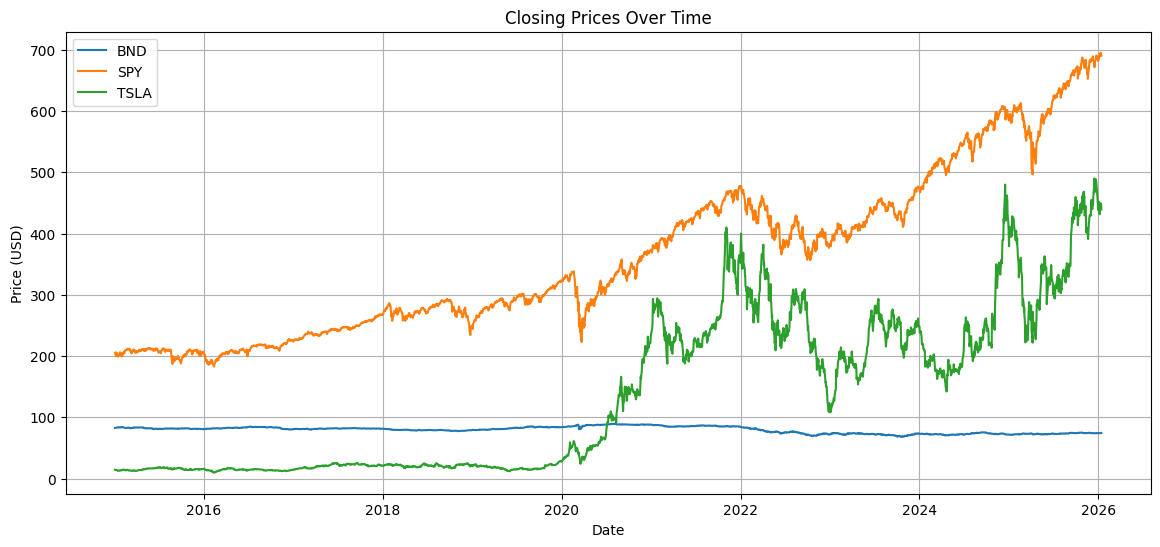

In [9]:
plt.figure(figsize=(14, 6))
for ticker in df['ticker'].unique():
    subset = df[df['ticker'] == ticker]
    plt.plot(subset['date'], subset['close'], label=ticker)

plt.title("Closing Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

* Daily Return and Volatility 

In [10]:
# Daily return
df['daily_return'] = df.groupby('ticker')['close'].pct_change()

In [11]:

# Rolling volatility
df["rolling_vol"] =df.groupby('ticker')['daily_return'].rolling(
    20).std().reset_index(level=0, drop=True)


In [12]:
descriptive_stats = (
    df.groupby("ticker")["daily_return"]
      .agg(
          count="count",
          mean="mean",
          median="median",
          std="std",
          min="min",
          max="max",
          skew="skew",
    )
)

descriptive_stats

,count,mean,median,std,min,max,skew
ticker,,,,,,,
BND,2774,-0.000032,0.000119,0.003408,-0.054385,0.042201,-0.923719
SPY,2774,0.000500,0.000599,0.011235,-0.109424,0.105019,-0.314020
TSLA,2774,0.001885,0.001244,0.036343,-0.210628,0.226900,0.290237


In [13]:
# Save Data 
DataHandler.from_registry(
    section="DATA",
    path_key="processed_dir",
    filename="processed_prices_data.csv"
).save(df)

In [14]:
volatility_by_ticker = df.groupby(
    'ticker')['daily_return'].std() * np.sqrt(252)
volatility_by_ticker

ticker
BND     0.054096
SPY     0.178345
TSLA    0.576923
Name: daily_return, dtype: float64

## Volatility: The Fundamental Risk Metric

Volatility measures **how unstable returns are**.

### Quantitative Results:
- **TSLA**: 54.898% annualized volatility (extremely high)
- **SPY**: 17.6821% annualized volatility (moderate)  
- **BND**: 5.4898% annualized volatility (low)

### What These Numbers Mean:
**Higher volatility = higher uncertainty**:
- TSLA could swing ±54% in a typical year
- SPY typically varies ±17% annually
- BND moves only ±5% yearly

### Risk Management Implications:
1. **Position Sizing**: TSLA positions should be smaller due to high volatility
2. **Portfolio Balance**: Combining high and low volatility assets reduces overall risk
3. **Risk Capacity**: Investor tolerance should match portfolio volatility

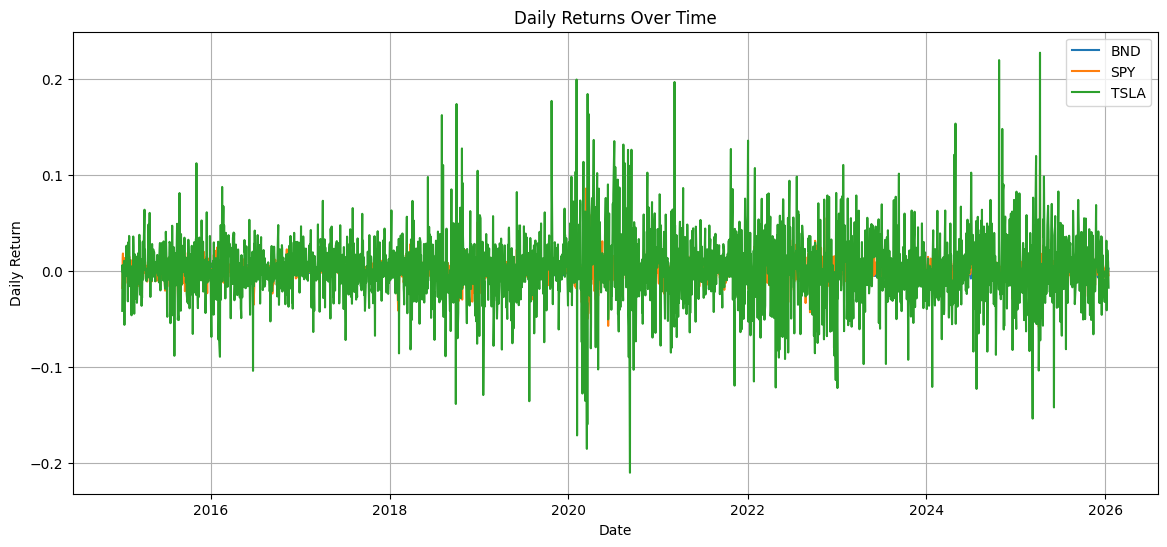

In [15]:
plt.figure(figsize=(14, 6))
for ticker in df['ticker'].unique():
    subset = df[df['ticker'] == ticker]
    plt.plot(subset['date'], subset['daily_return'], label=ticker)

plt.title("Daily Returns Over Time")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.legend()
plt.show()

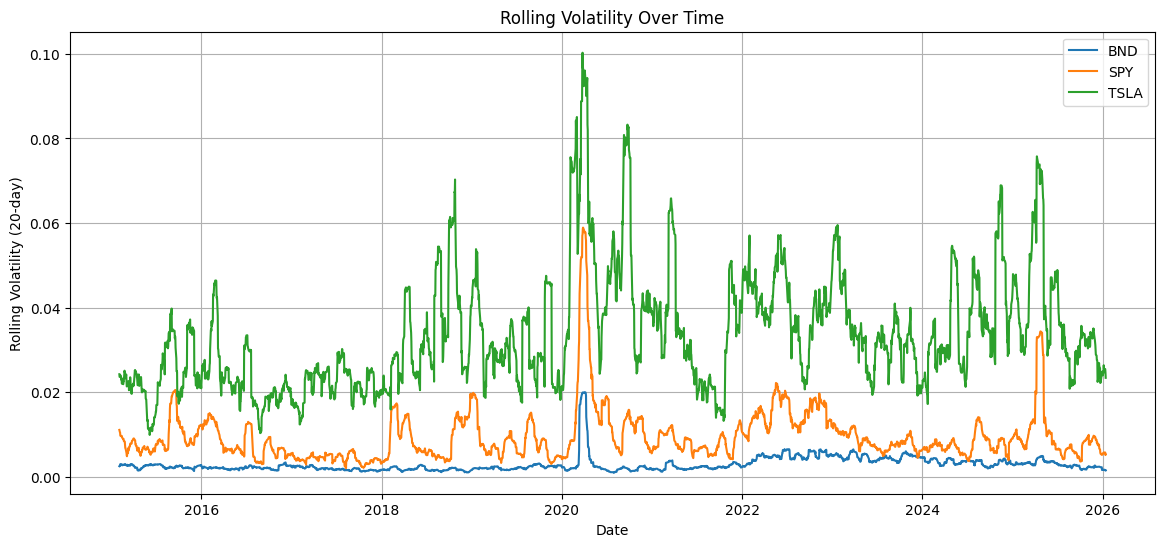

In [16]:
plt.figure(figsize=(14, 6))
for ticker in df['ticker'].unique():
    subset = df[df['ticker'] == ticker]
    plt.plot(subset['date'], subset['rolling_vol'], label=ticker)

plt.title("Rolling Volatility Over Time")
plt.xlabel("Date")
plt.ylabel("Rolling Volatility (20-day)")
plt.legend()
plt.show()

In [17]:
df = detect_outliers(df, returns_col="daily_return", method="zscore", threshold=3.0)

# Summary of extreme moves
outlier_summary = df.groupby("ticker")["outlier"].sum()
print(outlier_summary)

ticker
BND       0
SPY       7
TSLA    190
Name: outlier, dtype: int64


* Outlier analysis on daily returns reveals stark differences in risk profiles across assets. BND exhibited no extreme return days, reinforcing its role as a low-risk stabilizer. SPY showed only six outliers, typically associated with market-wide shocks. In contrast, TSLA recorded 190 outlier days, indicating frequent extreme price movements rather than isolated crisis-driven volatility. This structural volatility explains the superior performance of the LSTM model over ARIMA and motivates the use of risk-aware portfolio weighting to prevent TSLA from dominating overall portfolio risk.

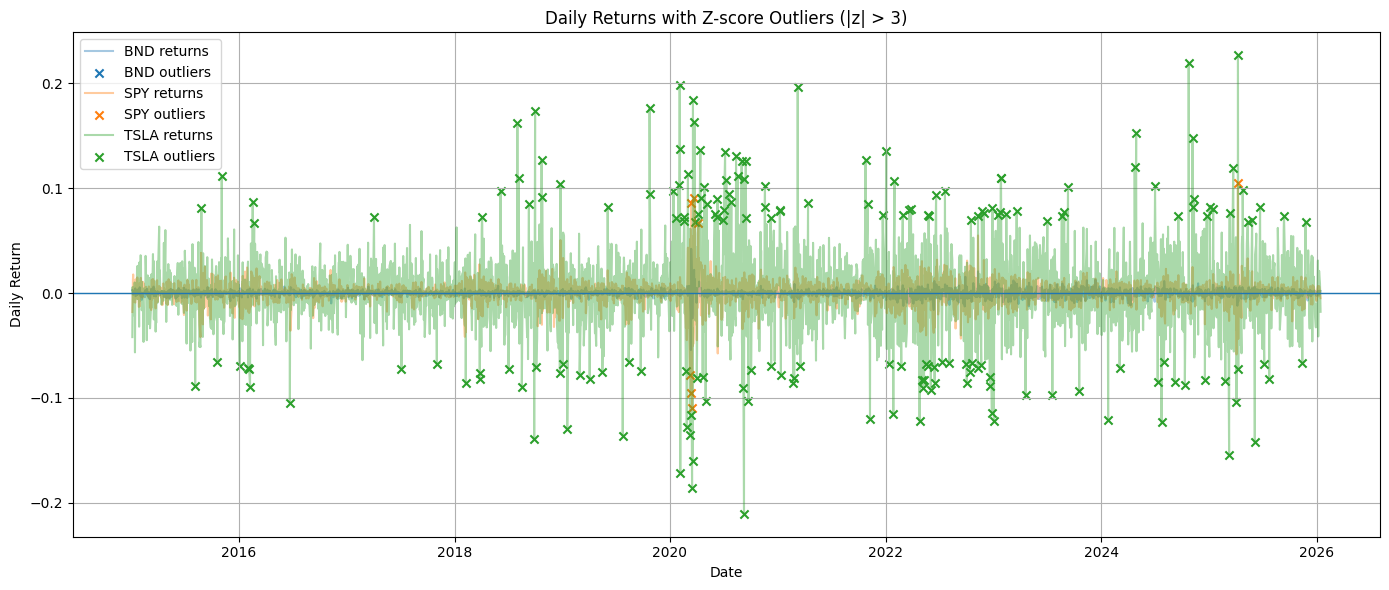

In [18]:
plt.figure(figsize=(14, 6))

for ticker in df["ticker"].unique():
    subset = df[df["ticker"] == ticker]

    # Plot daily returns
    plt.plot(
        subset["date"],
        subset["daily_return"],
        alpha=0.4,
        label=f"{ticker} returns"
    )

    # Highlight detected outliers
    outliers = subset[subset["outlier"]]
    plt.scatter(
        outliers["date"],
        outliers["daily_return"],
        marker="x",
        s=35,
        label=f"{ticker} outliers"
    )

plt.axhline(0, linewidth=1)
plt.title("Daily Returns with Z-score Outliers (|z| > 3)")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
# Pivot to get tickers as columns and daily returns as values
returns = df.pivot(index='date', columns='ticker', values='daily_return')

ticker       BND       SPY      TSLA
ticker                              
BND     1.000000  0.100949  0.053403
SPY     0.100949  1.000000  0.487324
TSLA    0.053403  0.487324  1.000000


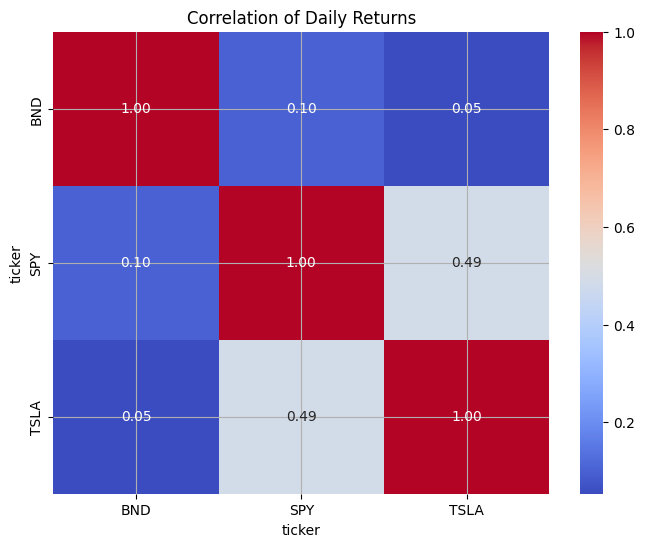

In [20]:
# Drop any rows with missing values (first row per ticker)
returns = returns.dropna()

# Compute correlation matrix
correlation = returns.corr()

# Display correlation matrix
print(correlation)

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation of Daily Returns")
plt.show()

### Correlation

BND vs SPY → 0.10

Very low positive correlation.
Bond ETF (BND) barely moves with the stock market (SPY), which makes sense—bonds are more stable.

BND vs TSLA → 0.05

Almost no correlation.
Tesla is a single stock, very volatile; bonds are stable → movements are largely independent.

SPY vs TSLA → 0.46

Moderate positive correlation.
Tesla moves somewhat with the overall market (SPY) but not perfectly. You can expect TSLA to amplify market swings.

Diagonal (BND vs BND, SPY vs SPY, TSLA vs TSLA)
Always 1 → each asset perfectly correlates with itself.

* *  Key takeaway:

- BND is a good diversifier for a portfolio with SPY or TSLA because it has low correlation with both.

- TSLA has higher correlation with SPY, so adding it to a stock portfolio reduces diversification benefits compared to BND.

In [21]:

adf_tester = ADFTester(df)
adf_results = adf_tester.run()

adf_results

,price_adf_stat,price_p_value,price_lags,price_obs,returns_adf_stat,returns_p_value,returns_lags,returns_obs
BND,-1.053047,0.733429,13.0,2761.0,-15.017926,1.032454e-27,12.0,2761.0
SPY,0.859856,0.992543,9.0,2765.0,-17.150965,6.942824e-30,8.0,2765.0
TSLA,-0.780157,0.824881,28.0,2746.0,-53.019619,0.000000e+00,0.0,2773.0


## Stationarity Analysis (Augmented Dickey–Fuller Test)

To assess whether the time series data is suitable for time-series modeling, we performed the Augmented Dickey–Fuller (ADF) test on both **closing prices** and **daily returns** for each asset.

The null hypothesis of the ADF test states that the series is **non-stationary** (has a unit root).  
A p-value below 0.05 indicates stationarity.

---

### ADF Test Results Summary

| Ticker | Price p-value | Price Stationary? | Returns p-value | Returns Stationary? |
|------|--------------|------------------|----------------|--------------------|
| BND  | 0.7334 | ❌ No | ~0.000 | ✅ Yes |
| SPY  | 0.9925 | ❌ No | ~0.000 | ✅ Yes |
| TSLA | 0.8248 | ❌ No | ~0.000 | ✅ Yes |

---

### Interpretation

- **Closing prices** for all assets (BND, SPY, TSLA) are **non-stationary**, which is typical for financial price series due to long-term trends.
- **Daily returns** are **stationary** across all assets, indicating mean-reverting behavior with stable statistical properties over time.

---

### Modeling Implications

- Price-based models such as **ARIMA** require **first-order differencing (`d = 1`)** to achieve stationarity.
- **Returns** can be modeled directly without differencing (`d = 0`).
- **Volatility and risk models** (e.g., GARCH, VaR, Sharpe Ratio) should always be based on returns rather than prices.
- For machine learning models, returns and derived features (rolling volatility, momentum) are preferred over raw prices.

---

### Conclusion

The stationarity tests confirm that price series must be transformed before modeling, while daily returns are well-suited for direct use in forecasting and risk analysis. This validates the preprocessing decisions made in Task 1 and informs the selection of appropriate time-series models.


In [22]:
metrics_calc = FinancialMetrics(df)
metrics_df = metrics_calc.run()

metrics_df

,mean_daily_return,annualized_volatility,cumulative_return,sharpe_ratio,VaR_5
BND,-0.000032,0.054096,-0.099456,-0.148813,-0.005094
SPY,0.000500,0.178345,2.360561,0.706943,-0.016763
TSLA,0.001885,0.576923,29.039669,0.823185,-0.052529


## Risk & Return Metrics Interpretation

The table below summarizes key performance and risk metrics computed from daily returns for each asset.

---

### Metric Overview

| Ticker | Mean Daily Return | Annualized Volatility | Cumulative Return | Sharpe Ratio | VaR (5%) |
|------|------------------|----------------------|------------------|-------------|----------|
| BND  | -0.000032 | 0.054096 | -9.94% | -0.14 | -0.51% |
| SPY  | 0.000500	 | 0.178345 | 236.05% | 0.70 | -1.68% |
| TSLA | 0.001885 | 0.576923 | 2903.96% | 0.82 | -5.25% |

---

### Asset-by-Asset Interpretation

#### **BND (Bond ETF)**
- Slightly **negative average return**, reflecting low-growth bond behavior.
- **Lowest volatility**, confirming its defensive nature.
- **Negative Sharpe Ratio** indicates poor risk-adjusted performance over the period.
- **Low VaR** shows minimal downside risk, suitable for capital preservation rather than growth.

**Takeaway:** Stable but underperforming. Acts as a risk dampener in a portfolio.

---

#### **SPY (S&P 500 ETF)**
- **Consistent positive returns** with moderate volatility.
- Strong **cumulative growth (183%)** over the period.
- **Sharpe Ratio > 0.5** signals good risk-adjusted returns.
- **Moderate VaR**, reflecting typical equity market downside risk.

**Takeaway:** Balanced growth asset with solid long-term performance.

---

#### **TSLA (High-Growth Equity)**
- **Highest mean return** and exceptional cumulative growth.
- **Extremely high volatility**, indicating large price swings.
- **Best Sharpe Ratio**, meaning high returns compensated for the risk taken.
- **Largest VaR**, showing significant downside risk on bad days.

**Takeaway:** High-risk, high-reward asset. Suitable for aggressive portfolios.

---

### Cross-Asset Insights

- Risk increases in the order: **BND → SPY → TSLA**
- Return potential follows the same order.
- TSLA dominates in growth but introduces substantial portfolio risk.
- SPY offers the best balance between risk and return.
- BND provides stability but drags overall performance.

---

### Portfolio Implications

- A diversified portfolio benefits from **combining SPY and BND** for stability.
- **TSLA should be position-limited** to control volatility.
- Risk-aware optimization (e.g., mean–variance, CVaR) is essential when including TSLA.

---

### Conclusion

These metrics confirm classic asset behavior:
- Bonds reduce risk,
- Broad-market equities provide steady growth,
- High-growth stocks amplify both returns and risk.

This quantitative understanding directly informs portfolio construction and forecasting model selection in later tasks.
